# Сравнение функций правдоподобия для метода статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
from modules.randomized_ir import RandomizedIr, RandomizedIrStats
import modules.utils as utils

In [4]:
from random import random

L_true = 3.5
ir_x = np.linspace(0, L_true, int(L_true * 100))
ir_y = np.exp(-ir_x)
rir = RandomizedIr(ir_x, ir_y, factor=lambda: 0.5 + random() * 0.5)

In [5]:
N = 10
n_vec_mean = 20
n_vec = utils.generate_poissonian_ns(n_vec_mean, N)

s_vec = rir.convolve_with_n_vec(n_vec)

In [6]:
stats = RandomizedIrStats(rir, samplesize=10 ** 5)

In [7]:
rng = np.random.default_rng()

# will evaluate likelihood around here
n_vec_estimation = stats.estimate_n_vec(s_vec)

# creating evaluation points grouped somwhere around maximum likelihood point
N_evaluation_points = 30
spread_from_estimation = 1  # from n_vec_estimation, in n units
evaluation_points = np.tile(n_vec_estimation, (N_evaluation_points, 1)) + rng.normal(scale=spread_from_estimation, size=(N_evaluation_points, N))

In [8]:
@utils.timer(args_formatter=lambda l, p: l.__name__ + f', {p.shape[0]} points')
def evaluate_loglike(loglike, points):
    results = []
    for p in tqdm(points):
        results.append(np.exp(loglike(p)))  # converting loglike back to regular PDF for comparison
    return np.array(results)

In [8]:
normdist_results = evaluate_loglike(stats.get_loglikelihood_normdist(s_vec), evaluation_points)

np.savetxt('../precomputed/normdist_results.txt', normdist_results)

100%|██████████| 30/30 [00:00<00:00, 68.50it/s]

evaluate_loglike(loglikelihood_normdist, 30 points) took 0.441 seconds to complete.



In [9]:
mc_results = evaluate_loglike(stats.get_loglikelihood_monte_carlo(s_vec), evaluation_points)
np.savetxt('../precomputed/mc_results.txt', mc_results)

  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [03:01<1:27:46, 181.59s/it]


  7%|▋         | 2/30 [06:04<1:24:57, 182.06s/it]


 10%|█         | 3/30 [09:06<1:21:50, 181.86s/it]


 13%|█▎        | 4/30 [12:07<1:18:46, 181.80s/it]


 17%|█▋        | 5/30 [15:10<1:15:49, 181.98s/it]


 20%|██        | 6/30 [18:18<1:13:29, 183.74s/it]


 23%|██▎       | 7/30 [21:23<1:10:34, 184.12s/it]


 27%|██▋       | 8/30 [24:28<1:07:41, 184.63s/it]


 30%|███       | 9/30 [27:32<1:04:28, 184.23s/it]


 33%|███▎      | 10/30 [30:35<1:01:16, 183.81s/it]


 37%|███▋      | 11/30 [33:37<58:05, 183.45s/it]  


 40%|████      | 12/30 [36:41<55:05, 183.62s/it]


 43%|████▎     | 13/30 [39:44<51:56, 183.32s/it]


 47%|████▋     | 14/30 [42:46<48:49, 183.07s/it]


 50%|█████     | 15/30 [45:52<45:56, 183.77s/it]


 53%|█████▎    | 16/30 [48:55<42:52, 183.77s/it]


 57%|█████▋    | 17/30 [51:56<39:37, 182.85s/it]


 60%|██████    | 18/30 [54:57<36:26, 182.20s/it]


 63%|██████▎   | 19/30 [57:56<33:14, 181.29s/it]


 67%|██████▋   | 20/30 [1:00:50<29:49, 178.99s/it]


 70%|███████   | 21/30 [1:03:39<26:24, 176.04s/it]


 73%|███████▎  | 22/30 [1:06:28<23:12, 174.11s/it]


 77%|███████▋  | 23/30 [1:09:30<20:35, 176.52s/it]


 80%|████████  | 24/30 [1:12:32<17:48, 178.14s/it]


 83%|████████▎ | 25/30 [1:15:34<14:56, 179.28s/it]


 87%|████████▋ | 26/30 [1:18:40<12:04, 181.06s/it]


 90%|█████████ | 27/30 [1:21:43<09:05, 181.87s/it]


 93%|█████████▎| 28/30 [1:24:45<06:03, 181.76s/it]


 97%|█████████▋| 29/30 [1:27:48<03:02, 182.28s/it]


100%|██████████| 30/30 [1:30:52<00:00, 181.75s/it]

evaluate_loglike(loglikelihood_monte_carlo, 30 points) took 5452.608 seconds to complete.



In [9]:
normdist_results = np.loadtxt('../precomputed/normdist_results.txt')
mc_results = np.loadtxt('../precomputed/mc_results.txt')

In [10]:
average = 0.5 * (normdist_results + mc_results)
residual = normdist_results - mc_results

print(f'values around {np.mean(average)}')
print(f'residual = {np.mean(residual)} +/- {np.std(residual)}')
print(f'relative = {100 * np.mean(residual / average):.2f} +/- {100 * np.std(residual / average):.2f}%')

values around 0.0023155141399187414
residual = 0.00016763725397184748 +/- 0.0011824804472728198
relative = 2.33 +/- 66.13%


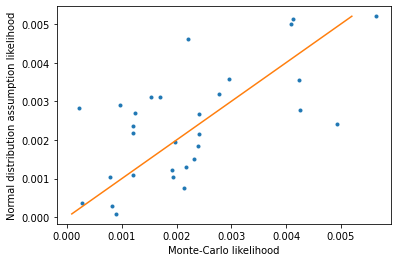

In [11]:
min_l = min(normdist_results.min(), mc_results.min())
max_l = min(normdist_results.max(), mc_results.max())
rng_l = np.linspace(min_l, max_l)

plt.plot(mc_results, normdist_results, '.')
plt.plot(rng_l, rng_l)

plt.xlabel('Monte-Carlo likelihood')
plt.ylabel('Normal distribution assumption likelihood')
# plt.yscale('log')
# plt.xscale('log')
plt.show()